In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.tsa.stattools as tsa
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.api import qqplot
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

warnings.filterwarnings(action='ignore') # Ignore warning message

# date path
data_path = '../Data/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

Data Downcasting

In [2]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
        if df[col].dtype.name=="float64":
            df[col] = df[col].astype('float32')
            
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.5% compressed
54.2% compressed
39.8% compressed
70.8% compressed


## EDA and Data Preprocessing

### (0) Overview

In [3]:
comb_data = sales_train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
display(comb_data.head().T)
display(comb_data.describe().T)
display(comb_data.dtypes)

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.0,899.0,899.0,1709.050049,1099.0
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853210,1729.799683,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0
item_category_id,2935849.0,40.001383,17.100759,0.0,28.0,40.0,55.0,83.0


date                   object
date_block_num           int8
shop_id                  int8
item_id                 int16
item_price            float32
item_cnt_day            int16
item_name              object
item_category_id         int8
shop_name              object
item_category_name     object
dtype: object

### (1) Shops: create derived features ('city') and encode

Notes after checking, decide to do 4 things:
- Some shops have multiple id since they have franchise and non-franchise shops ---> decide to merge those id into one
- The first world of the shop name represents city ---> derive and encode 'city' column
- Only keep shop names shop ids that appeared in test set
- Drop 'shop name' column

In [4]:
shops.loc[:10, ['shop_name']]['shop_name'].unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?'], dtype=object)

In [5]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [6]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])

In [7]:
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [8]:
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [9]:
# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])

In [10]:
#  Modify shop_id in sales_train data
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

In [11]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
# unique_test_item_id = test['item_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
# sales_train = sales_train[sales_train['item_id'].isin(unique_test_item_id)]

In [12]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### (2) itmes: Create derived features

Notes after checking, decide to do 3 things:
- Some Category_name can be grouped into the same Category --> Extract the first world ---> Derive 'Category' column and encode
- Group all minority categories with subcategories less than 5 into "etc"
- Drop 'item_category_name' column

In [13]:
item_categories.loc[:10, ['item_category_name']]['item_category_name'].unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2'], dtype=object)

In [14]:
# Extract the first word of the item_categories_name into category
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  
item_categories['category'].value_counts()

category
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [15]:
def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc)

In [16]:
item_categories.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [17]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

# Remove item_category_name feature
item_categories = item_categories.drop('item_category_name', axis=1)

In [18]:
item_categories.head()

,item_category_id,category
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


### (3) itmes: Create derived features

Notes after checking, decide to do 4 things:
- Drop 'item_name' column
- Only keep items that appears in the test set
- Derive column 'first_sale_date'


In [19]:
# Remove item_name feature
items = items.drop(['item_name'], axis=1)

In [20]:
# Leaking to imporve performance
unique_test_item_id = test['item_id'].unique()
sales_train = sales_train[sales_train['item_id'].isin(unique_test_item_id)]

In [21]:
# Create the date the product was first sold as a feature
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [22]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
...,...,...,...
22160,22160,40,NaN
22161,22161,37,NaN
22165,22165,31,NaN
22168,22168,62,NaN


In [23]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

### (4) sales_train

Notes after checking, decide to do 3 things:
- check the range of 'date'
- derive 'year' and 'month' columns for both sales_train and test data
- check 'item_price' and 'item_cnt_dat' range ---> remove outliers

Time period of the dataset

Notes:
- Checking the range of the date time period
- Derive 'month' and 'year' column
- Check the range of the 'item_cnt' and 'item_price' ---> remove outliers

In [24]:
print('Min date from train set: %s' % pd.to_datetime(sales_train['date'], format='%d.%m.%Y').min().date())
print('Max date from train set: %s' % pd.to_datetime(sales_train['date'], format='%d.%m.%Y').max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-10-31


In [25]:
# Extract time based features.
sales_train['year'] = sales_train['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales_train['month'] = sales_train['date_block_num'].apply(lambda x: (x % 12))
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.0,1,2013,0
10,03.01.2013,0,25,2574,399.0,2,2013,0
11,05.01.2013,0,25,2574,399.0,1,2013,0
12,07.01.2013,0,25,2574,399.0,1,2013,0
13,08.01.2013,0,25,2574,399.0,2,2013,0


In [26]:
test['date_block_num'] = 34
test['year'] = test['date_block_num'].apply(lambda x: ((x//12) + 2013))
test['month'] = test['date_block_num'].apply(lambda x: (x % 12))
test.head()

,ID,shop_id,item_id,date_block_num,year,month
0,0,5,5037,34,2015,10
1,1,5,5320,34,2015,10
2,2,5,5233,34,2015,10
3,3,5,5232,34,2015,10
4,4,5,5268,34,2015,10


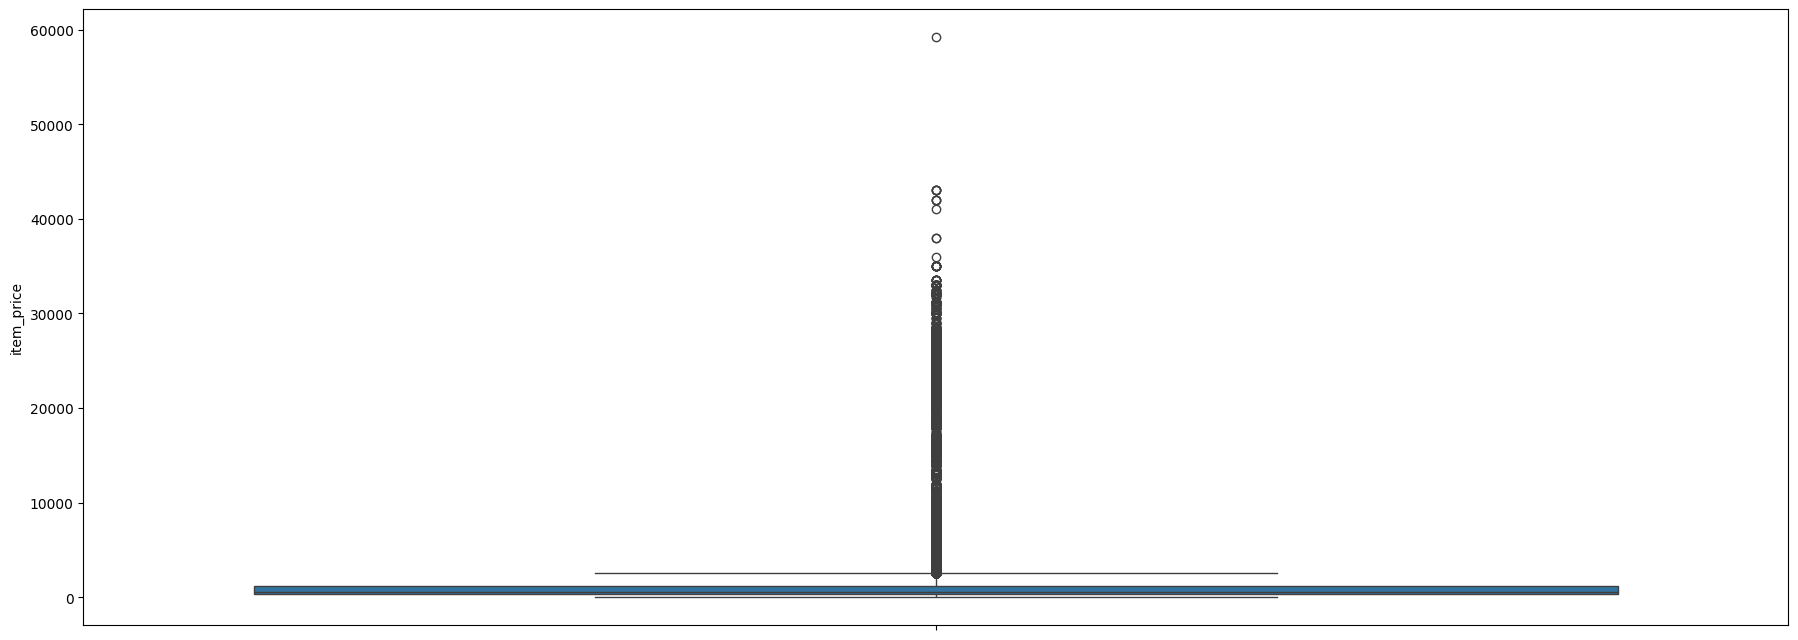

In [27]:
plt.subplots(figsize=(22, 8))
sns.boxplot(sales_train['item_price'])
plt.show()

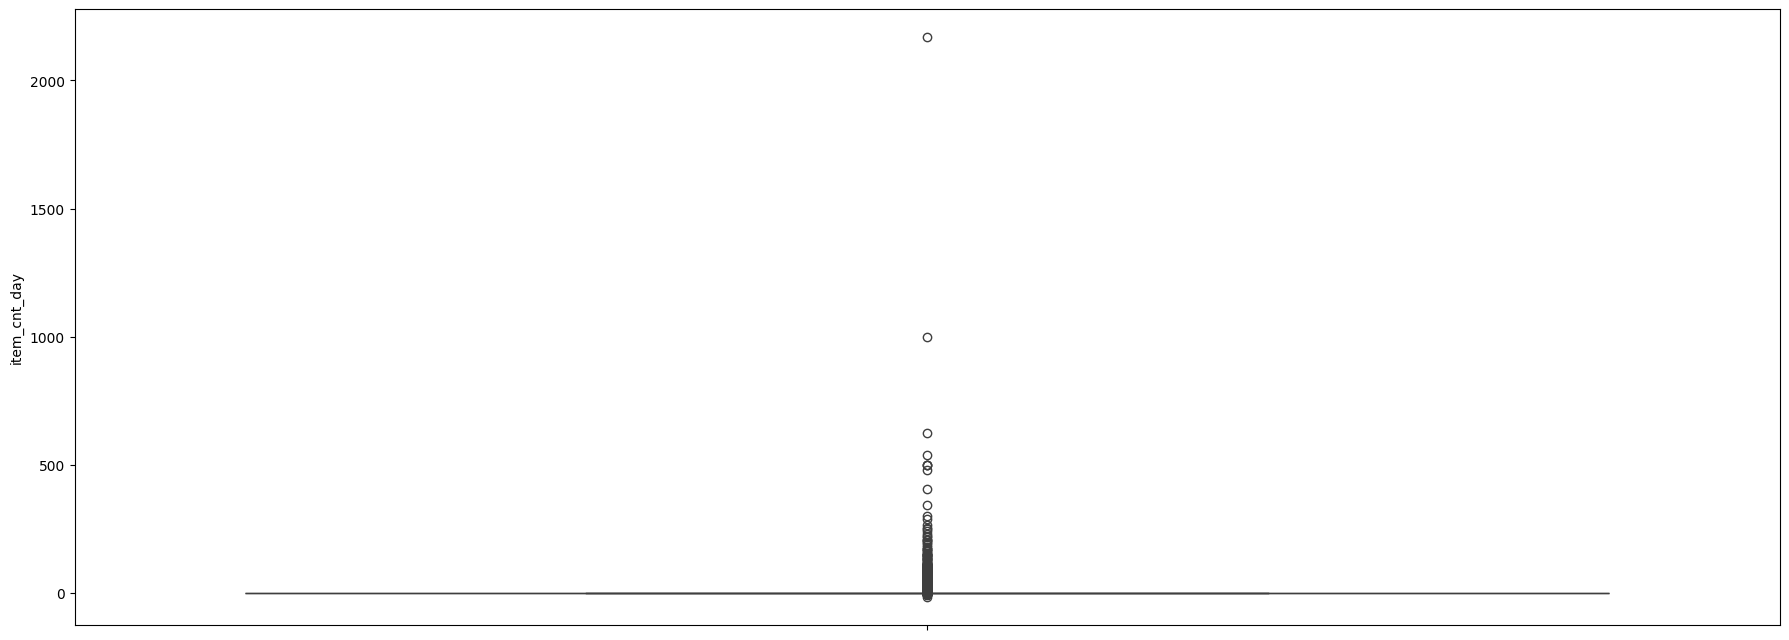

In [28]:
plt.subplots(figsize=(22, 8))
sns.boxplot(sales_train['item_cnt_day'])
plt.show()

In [29]:
# Extract data with a item_price greater than 0
sales_train = sales_train[sales_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
sales_train = sales_train[sales_train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

### (5) Generate data combinations and derived features

Notes:
- Create a shell containing all combinations of 'date_block_num', 'shop_id', 'item_id'
- Derive aggragated variables base on the combined index
    a.'item_cnt_month'
    b.'item_price_mean'
    c.'item_count'
- Concatenate sales_train data + 'test'
- Merge the remaining data (shops, items, item_categories)
- Derive 'duration_after_first_sale' and drop 'first_sale_date'

In [30]:
from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)  # ertically stack arrays
train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2574
2,0,59,2607
3,0,59,2614
4,0,59,2808


In [31]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2574,2.0,399.0
2,0,59,2607,NaN,NaN
3,0,59,2614,NaN,NaN
4,0,59,2808,15.0,999.0


In [32]:
import gc

# group variable garbage collection
del group
gc.collect()

5504

In [33]:
# Add a feature for the number of items sold
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# Garbage collection
del group
gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2574,2.0,399.0,2.0
2,0,59,2607,NaN,NaN,NaN
3,0,59,2614,NaN,NaN,NaN
4,0,59,2808,15.0,999.0,9.0


In [34]:
# Concatenate test data, Merge remaining data

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)

# Replace NaN with 0
all_data = all_data.fillna(0)
all_data['year'] = all_data['year'].astype('int32')
all_data['month'] = all_data['month'].astype('int32')

display(all_data.head())
display(all_data.tail())

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month
0,0,59,22154,1.0,999.0,1.0,0,0
1,0,59,2574,2.0,399.0,2.0,0,0
2,0,59,2607,0.0,0.0,0.0,0,0
3,0,59,2614,0.0,0.0,0.0,0,0
4,0,59,2808,15.0,999.0,9.0,0,0


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month
2952842,34,45,18454,0.0,0.0,0.0,2015,10
2952843,34,45,16188,0.0,0.0,0.0,2015,10
2952844,34,45,15757,0.0,0.0,0.0,2015,10
2952845,34,45,19648,0.0,0.0,0.0,2015,10
2952846,34,45,969,0.0,0.0,0.0,2015,10


In [35]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del shops, items, item_categories
gc.collect();

72.3% compressed


In [36]:
display(all_data.head())
display(all_data.tail())

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month,city,item_category_id,category,duration_after_first_sale
0,0,59,22154,1,999.0,1,0,0,30,37,5,0
1,0,59,2574,2,399.0,2,0,0,30,55,7,0
2,0,59,2607,0,0.0,0,0,0,30,55,7,0
3,0,59,2614,0,0.0,0,0,0,30,55,7,0
4,0,59,2808,15,999.0,9,0,0,30,30,3,0


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month,city,item_category_id,category,duration_after_first_sale
2952842,34,45,18454,0,0.0,0,2015,10,20,55,7,11
2952843,34,45,16188,0,0.0,0,2015,10,20,64,8,2
2952844,34,45,15757,0,0.0,0,2015,10,20,55,7,34
2952845,34,45,19648,0,0.0,0,2015,10,20,40,5,11
2952846,34,45,969,0,0.0,0,2015,10,20,37,5,17


In [37]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [38]:
resumetable(all_data)

Data Shape: (2952847, 12)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int8,0,35,0.0,0.0,0.0
shop_id,int8,0,42,59.0,59.0,59.0
item_id,int16,0,5100,22154.0,2574.0,2607.0
item_cnt_month,int16,0,383,1.0,2.0,0.0
item_price_mean,float32,0,23018,999.0,399.0,0.0
item_count,int8,0,40,1.0,2.0,0.0
year,int16,0,2,0.0,0.0,0.0
month,int8,0,2,0.0,0.0,0.0
city,int8,0,28,30.0,30.0,30.0
item_category_id,int8,0,62,37.0,55.0,55.0


### Visualization

Notes:
- Time Series 
    - Predict for the total sales per month for all the companies.
        - Line plot 
        - Rolling window line plot
        - Checking stationarity
        - Checking white noises

    - Clues after checking:
      - There are obvious seasonal and upward trend patterns
      - Data are not stationery, need to stationize data before fitting ARMA model
      - When modeling, we will fit the time series model first and obtain the prediction
        Then calculate residuals = y_actual - y_pred_Time_series
        Lastly, fit the residual on the other remaining models




- Other features:
  - Distribution of monthly item counts by date block number
  - Distribution of total item counts by item category id


### Time series:
Predict for the total sales per month for the entire company.
First let's compute the total sales per month and plot that data.

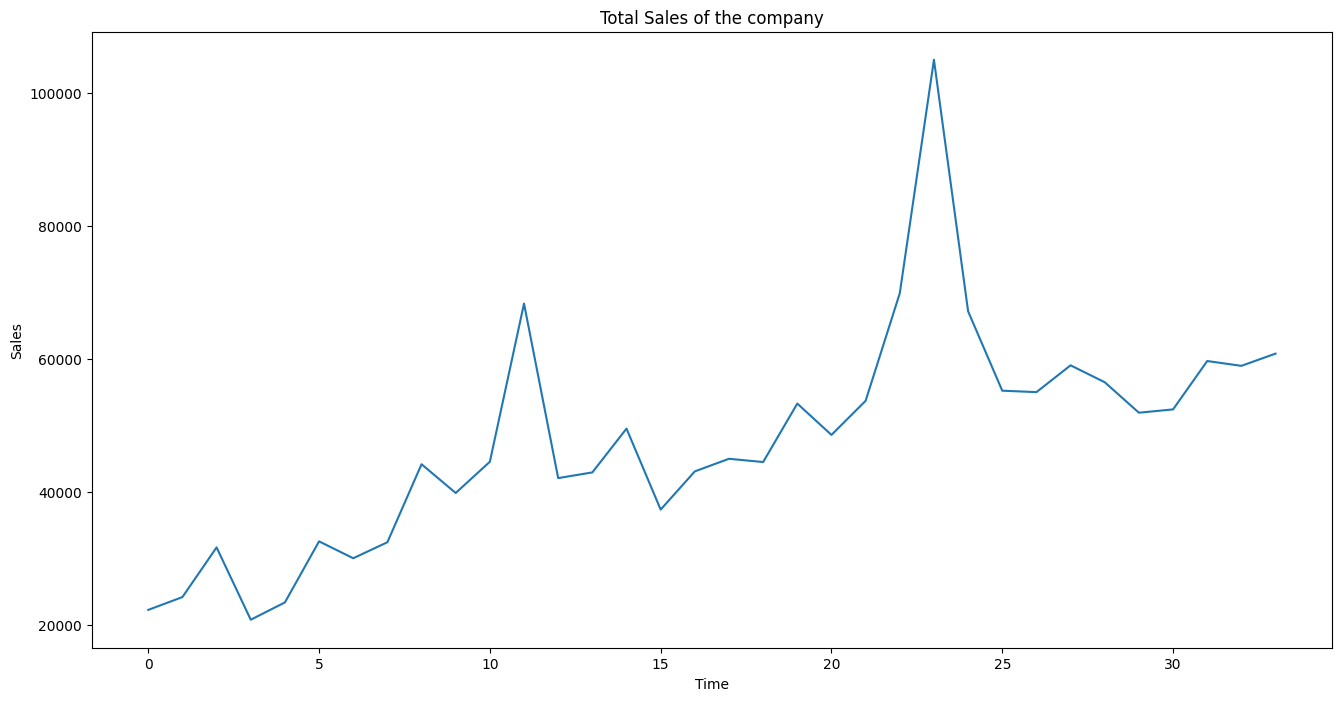

In [39]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

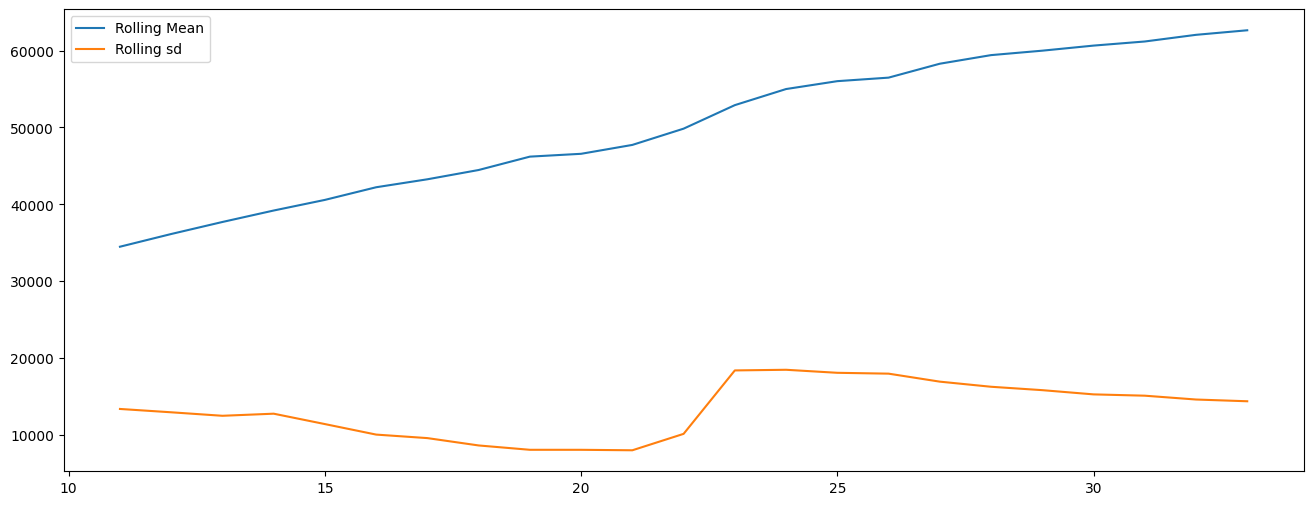

In [40]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

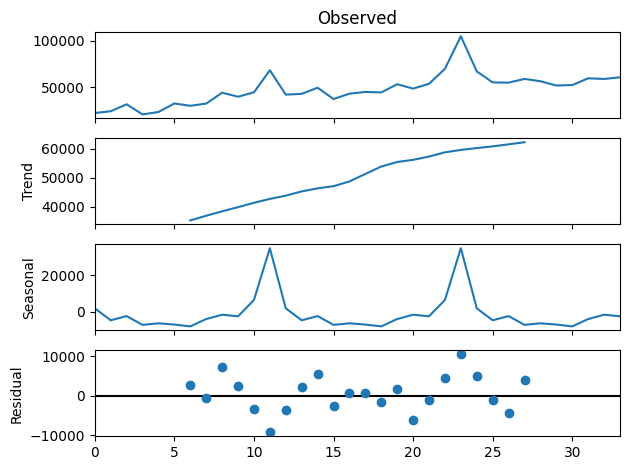

In [41]:
import statsmodels.api as sm

# Additive model
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

Additive model:

yt=St+Tt+Et

where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t Similarly for Multiplicative model,


###  Stationarity:

What does it mean for data to be stationary? 
1. The mean of the series should not be a function of time. 
2. The variance of the series should not be a function of time. This property is known as homoscedasticity. 
3. Finally, the covariance of the i th term and the (i + m) th term should not be a function of time.



Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

There are multiple tests that can be used to check stationarity.

    ADF( Augmented Dicky Fuller Test)
    KPSS
    PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.

In [42]:
result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.531545363826329
p-value: 0.1079864168169592
Critical Values: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


p-value: The p-value is greater than the chosen significance level (usually 0.05), so fail to reject the null hypothesis and conclude that the series is not stationary.

Try De-Trend and De-seasonalization

In [43]:
# to remove trend
from pandas import Series as Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

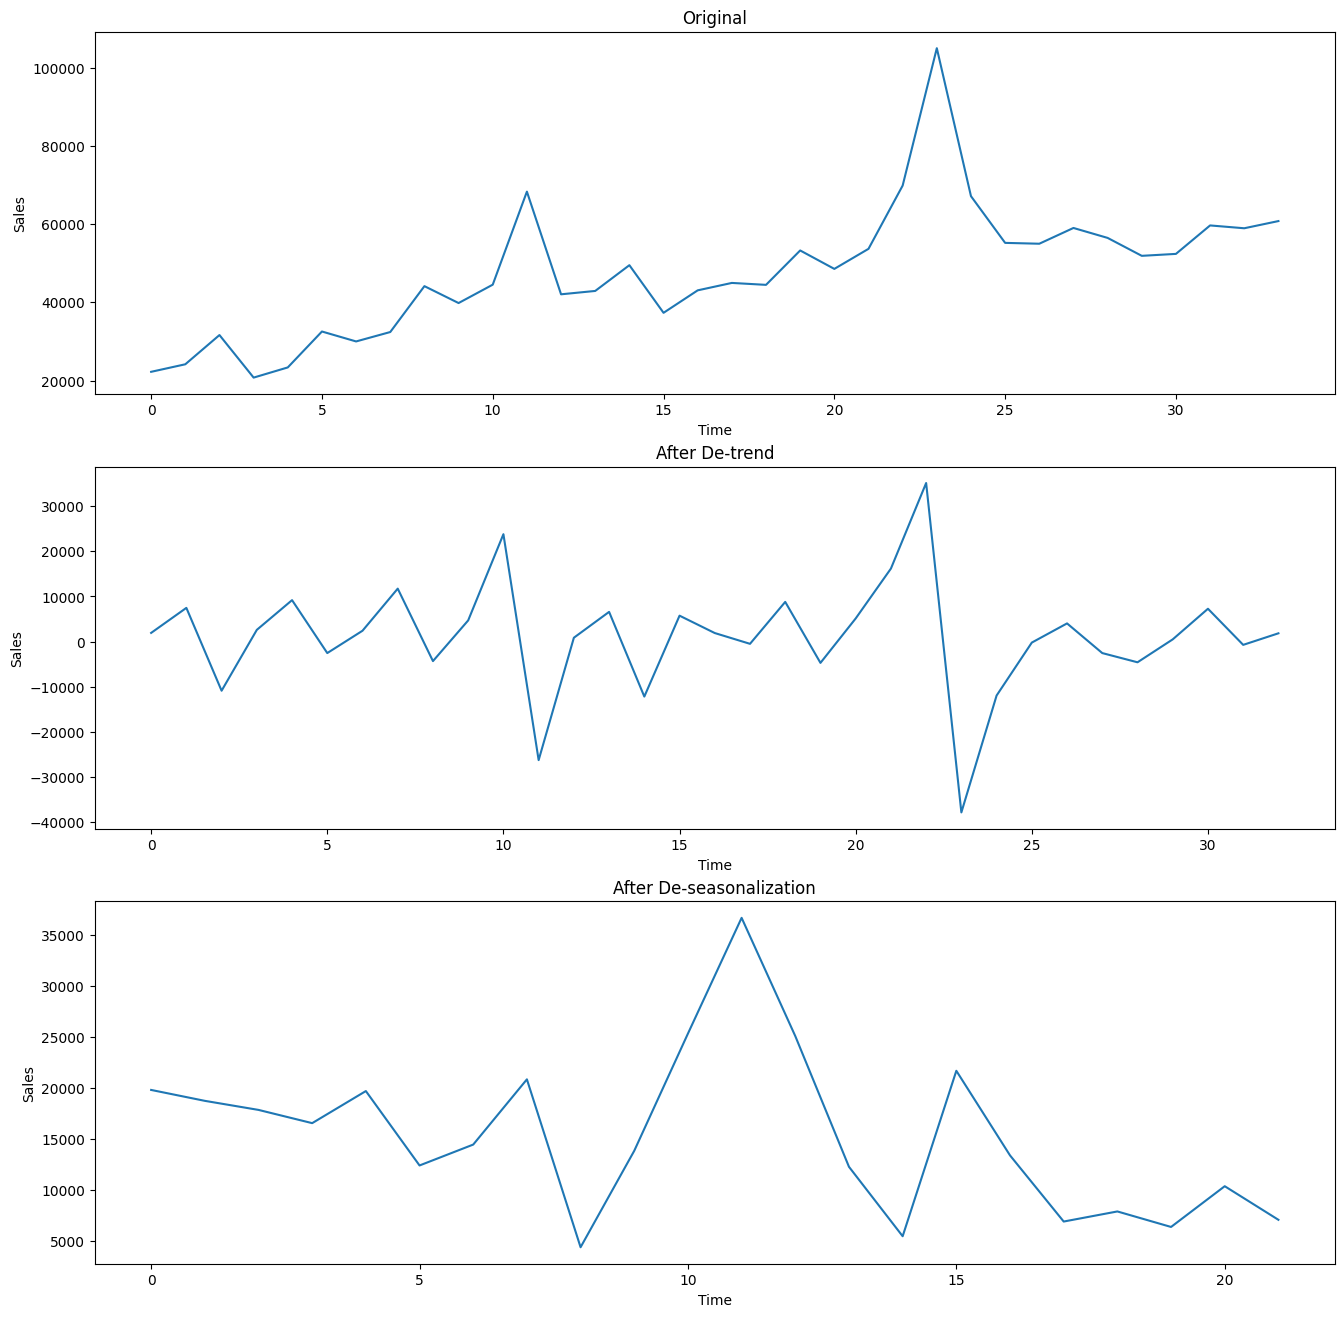

In [44]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts1=difference(ts)
plt.plot(new_ts1)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts2=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts2)
plt.plot()

In [45]:
# now testing the stationarity again after de-trend
result = adfuller(new_ts1)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -10.540883732703339
p-value: 8.656443461392812e-19
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}


In [46]:
# now testing the stationarity again after de-seasonality
result = adfuller(new_ts2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.4868759195588772
p-value: 0.5399933560663104
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}


##### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

We can easily get back the original series using the inverse transform function that we have defined above.

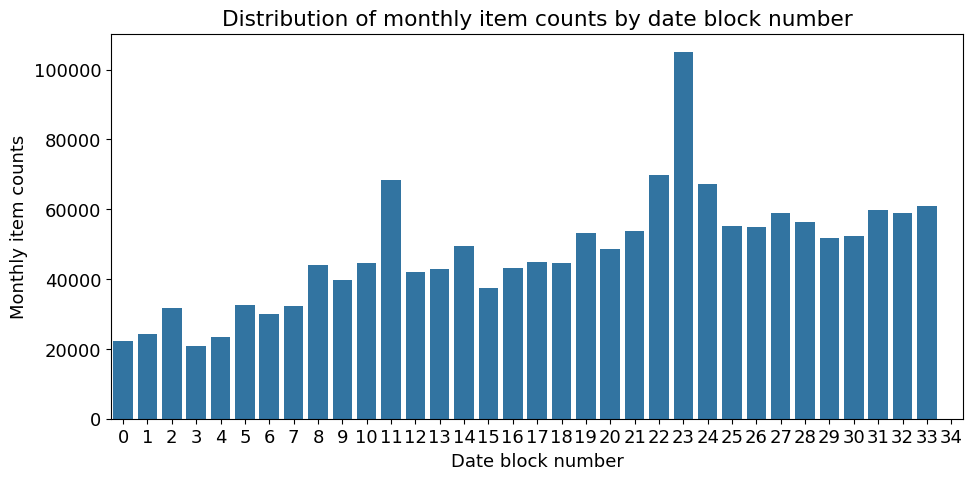

In [47]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = all_data.groupby('date_block_num',as_index=False).agg({'item_cnt_month': 'sum'})
# group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

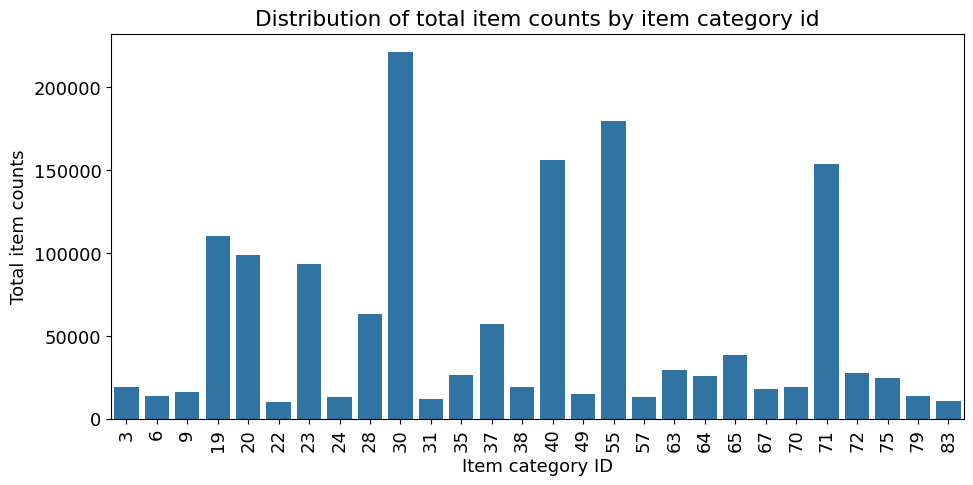

In [48]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = all_data.groupby('item_category_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='item_category_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

## Feature Engineering - Create mean features and Lag features
Create Average Monthly Sales Derived Feature by Base Feature

- Average Mongthly Sales Derived fFeature by Base Features
    - 'item_id_mean_sales'
    - 'item_id_city_mean_sales'
    - 'shop_id_item_category_id_mean_sales'

- Lag features
    - item_count_lag1 ~ item_count_lag3
    - item_price_mean_lag1 ~ item_price_mean_lag3
    - item_id_mean_sales_lag1 ~ item_id_mean_sales_lag3
    - item_id_city_mean_sales_lag1 ~ item_id_city_mean_sales_lag3
    - shop_id_item_category_id_mean_sales_lag1 ~ shop_id_item_category_id_mean_sales_lag3

- Other Features
    - 'Duration_after_first_sales'
    - Remove variables that test data don't have info, such as 'Item_price_mean', 'Item_count'

In [49]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    #The first element in idx_features is 'date_block_num'.
    #The length of idx_features is either 2 or 3.
    #If these conditions are not met, an AssertionError will be raised.
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [50]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

In [51]:
item_mean_features

['item_id_mean_sales', 'item_id_city_mean_sales']

In [52]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [53]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

Create Lag Features

In [54]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += 1
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [55]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2574.000000,2607.000000,2614.000000,2808.000000
item_cnt_month,1.000000,2.000000,0.000000,0.000000,15.000000
item_price_mean,999.000000,399.000000,0.000000,0.000000,999.000000
item_count,1.000000,2.000000,0.000000,0.000000,9.000000
year,0.000000,0.000000,0.000000,0.000000,0.000000
month,0.000000,0.000000,0.000000,0.000000,0.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,55.000000,55.000000,55.000000,30.000000


In [56]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [57]:
lag_features_to_clip

[]

In [58]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2574.000000,2607.000000,2614.000000,2808.000000
item_cnt_month,1.000000,2.000000,0.000000,0.000000,15.000000
item_price_mean,999.000000,399.000000,0.000000,0.000000,999.000000
item_count,1.000000,2.000000,0.000000,0.000000,9.000000
year,0.000000,0.000000,0.000000,0.000000,0.000000
month,0.000000,0.000000,0.000000,0.000000,0.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,55.000000,55.000000,55.000000,30.000000


In [59]:
X_test_temp = all_data[all_data['date_block_num'] == 34]
X_test_temp[item_mean_features].sum()

item_id_mean_sales         0.0
item_id_city_mean_sales    0.0
dtype: float32

In [60]:
# Create lag features by item_mean_features element based on dx_features
display(item_mean_features)

for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

['item_id_mean_sales', 'item_id_city_mean_sales']

In [61]:
display(shop_mean_features)

# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

['shop_id_item_category_id_mean_sales']

In [62]:
# Remove data less than date ID 3
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

In [63]:
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2850127 entries, 102720 to 2952846
Data columns (total 25 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int16  
 4   year                                      int16  
 5   month                                     int8   
 6   city                                      int8   
 7   item_category_id                          int8   
 8   category                                  int8   
 9   duration_after_first_sale                 int8   
 10  item_count_lag1                           int8   
 11  item_count_lag2                           int8   
 12  item_count_lag3                           int8   
 13  item_price_mean_lag1                      float32
 1

In [64]:
display(all_data.head().T)
display(all_data.tail().T)

,102720,102721,102722,102723,102724
date_block_num,3.000000,3.000000,3.000000,3.000000,3.000000
shop_id,25.000000,25.000000,25.000000,25.000000,25.000000
item_id,8093.000000,8012.000000,8094.000000,8172.000000,8436.000000
item_cnt_month,5.000000,2.000000,2.000000,1.000000,1.000000
year,0.000000,0.000000,0.000000,0.000000,0.000000
month,0.000000,0.000000,0.000000,0.000000,0.000000
city,13.000000,13.000000,13.000000,13.000000,13.000000
item_category_id,38.000000,55.000000,37.000000,55.000000,49.000000
category,5.000000,7.000000,5.000000,7.000000,6.000000
duration_after_first_sale,3.000000,3.000000,3.000000,1.000000,3.000000


,2952842,2952843,2952844,2952845,2952846
date_block_num,34.000000,34.000000,34.000000,34.000000,34.000000
shop_id,45.000000,45.000000,45.000000,45.000000,45.000000
item_id,18454.000000,16188.000000,15757.000000,19648.000000,969.000000
item_cnt_month,0.000000,0.000000,0.000000,0.000000,0.000000
year,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
month,10.000000,10.000000,10.000000,10.000000,10.000000
city,20.000000,20.000000,20.000000,20.000000,20.000000
item_category_id,55.000000,64.000000,55.000000,40.000000,37.000000
category,7.000000,8.000000,7.000000,5.000000,5.000000
duration_after_first_sale,11.000000,2.000000,34.000000,11.000000,17.000000


## Train model and Submit

### (1) TS model

Using ACF and PACF plots to select p and q used in the ARIMA model

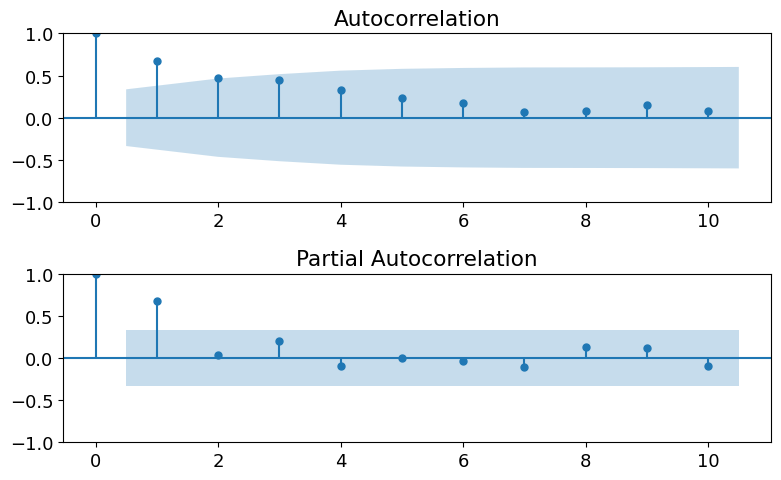

In [65]:
fig = plt.figure(figsize=(8,5)) # Create a figure object, set up size as (8, 5)
ax1 = fig.add_subplot(211)  # Add the 1st subfigure, it's the 1st one of the 2x1 figures
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)  # Add the 1st subfigure, it's the 1st one of the 2x1 figures
fig = sm.graphics.tsa.plot_pacf(ts.values.squeeze(), lags=10, ax=ax2)
plt.tight_layout()  #adjust the layout, making it more compact
plt.show()

In [66]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        tmp_mdl = smt.ARIMA(new_ts2, order=(i, 0, j), trend='n').fit()
        tmp_aic = tmp_mdl.aic
        if tmp_aic < best_aic:
            best_aic = tmp_aic
            best_order = (i, j)
            best_mdl = tmp_mdl


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 463.88461 | order: (1, 2)


We've identified the order of the simulated process as ARMA(1,2)

In [67]:
best_mdl = smt.ARIMA(new_ts2, order=(1, 0, 2), trend='n').fit()

### Residual Test

Check if residuals are white noise, if not, it indicates the patterns extracted by the model is not complete

<Axes: >

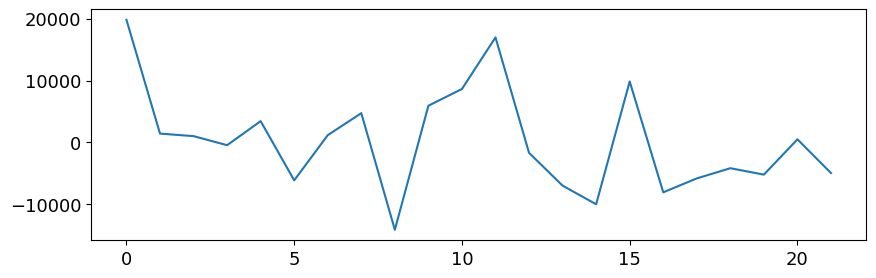

In [68]:
best_mdl.resid.plot(figsize=(10,3))

In [69]:
stats.normaltest(best_mdl.resid)

NormaltestResult(statistic=2.583363105437634, pvalue=0.27480828971850946)

1.6979993494978807


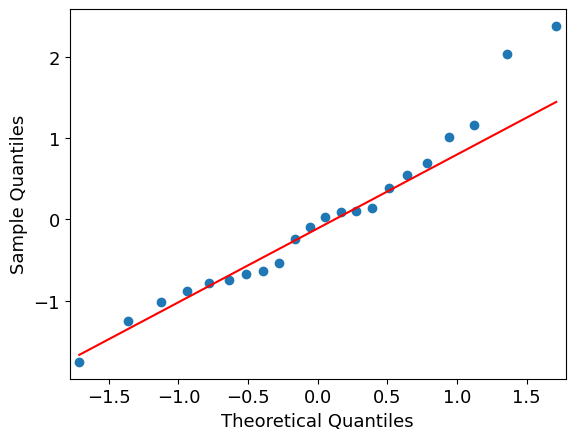

In [70]:
qqplot(best_mdl.resid, line="q", fit=True) # QQplot checks if residuals are normally distributted
print(sm.stats.durbin_watson(best_mdl.resid.values))  #DW Test

the p-value of the residul test is > 0.05, indicating the residuls is approximately normally distributed

### Simply use best_mdl.predict() to predict the next values

In [71]:
new_ts2

0     19833
1     18764
2     17876
3     16578
4     19723
5     12430
6     14478
7     20871
8      4414
9     13870
10    25356
11    36701
12    25108
13    12298
14     5493
15    21710
16    13417
17     6934
18     7923
19     6403
20    10397
21     7104
dtype: int64

In [72]:
pred = best_mdl.predict(1,23)
pred.index = pred.index-1
pred = inverse_difference(pred, ts.head(23))
pred.index = pred.index+12
display(pred)

date_block_num
12    39568.783994
13    41019.132675
14    48663.007285
15    37031.014637
16    41920.241662
17    45848.282332
18    46143.709584
19    50955.763124
20    52085.579868
21    56538.473267
22    64242.725790
23    95127.691936
24    61356.076727
25    58419.159761
26    61368.734218
27    58816.359029
28    55830.823003
29    57070.023671
30    56096.139181
31    63176.196767
32    60623.237002
33    62456.663077
34    80416.311183
dtype: float64

Text(0, 0.5, 'item_cnt_month___')

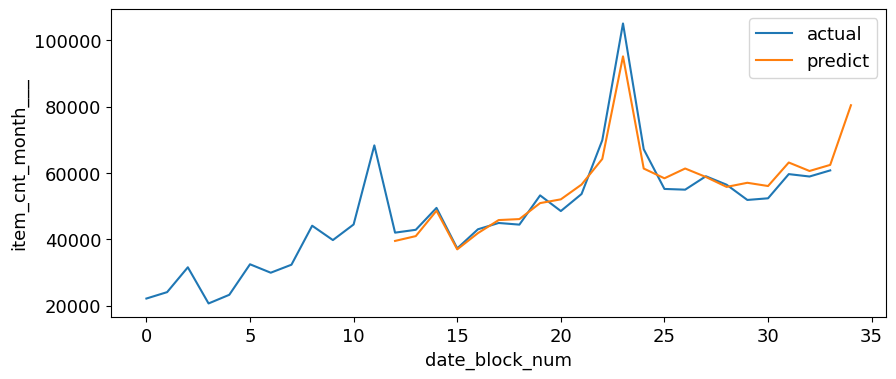

In [73]:
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts, label='actual_new_ts2')
plt.plot(pred.index, pred, label='predic')
plt.legend(['actual', 'predict'])
plt.xlabel('date_block_num')
plt.ylabel('item_cnt_month___')

The blue is reflects the actual new_ts2 values, and the orange line indicates the predicted values

### ARIMA Model Eveluation

In [74]:
print('rmse:', np.sqrt(mean_squared_error(ts[12:], pred[:22])))


rmse: 3780.4252834749636


In [75]:
predx = pd.DataFrame(pred, columns=["y_pred01"])
predx.reset_index(inplace=True)
predx.index = predx.index+12
predx

,date_block_num,y_pred01
12,12,39568.783994
13,13,41019.132675
14,14,48663.007285
15,15,37031.014637
16,16,41920.241662
17,17,45848.282332
18,18,46143.709584
19,19,50955.763124
20,20,52085.579868
21,21,56538.473267


In [76]:
all_data = all_data.join(predx, how='left', on='date_block_num', rsuffix='_').drop(['date_block_num_'], axis=1)
# all_data['y_resid'] = all_data['item_cnt_month'] - all_data['y_pred01']
# all_data.drop(['y_pred01'], axis=1, inplace=True)
display(all_data.head())
display(all_data.tail())

,date_block_num,shop_id,item_id,item_cnt_month,year,month,city,item_category_id,category,duration_after_first_sale,...,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,y_pred01
102720,3,25,8093,5,0,0,13,38,5,3,...,1.972222,1.944444,3.142857,3.428571,3.142857,7.428571,0.741935,0.807692,1.464286,NaN
102721,3,25,8012,2,0,0,13,55,7,3,...,0.500000,0.250000,0.628571,0.857143,0.571429,1.428571,1.039711,0.996350,1.015038,NaN
102722,3,25,8094,2,0,0,13,37,5,3,...,0.416667,0.500000,0.628571,0.857143,0.857143,0.428571,2.137500,1.809524,1.911392,NaN
102723,3,25,8172,1,0,0,13,55,7,1,...,0.055556,0.000000,0.000000,0.142857,0.000000,0.000000,1.039711,0.996350,1.015038,NaN
102724,3,25,8436,1,0,0,13,49,6,3,...,0.138889,0.222222,0.142857,0.285714,0.428571,0.428571,0.789474,0.432432,0.666667,NaN


,date_block_num,shop_id,item_id,item_cnt_month,year,month,city,item_category_id,category,duration_after_first_sale,...,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,y_pred01
2952842,34,45,18454,0,2015,10,20,55,7,11,...,0.047619,0.024390,0.073171,0.5,0.0,0.0,0.136738,0.076389,0.122083,80416.311183
2952843,34,45,16188,0,2015,10,20,64,8,2,...,0.023810,0.073171,0.000000,0.0,0.0,0.0,0.115385,0.141304,0.258824,80416.311183
2952844,34,45,15757,0,2015,10,20,55,7,34,...,0.119048,0.073171,0.097561,0.0,0.5,0.0,0.136738,0.076389,0.122083,80416.311183
2952845,34,45,19648,0,2015,10,20,40,5,11,...,0.047619,0.073171,0.146341,0.0,0.0,0.0,0.116788,0.110672,0.159915,80416.311183
2952846,34,45,969,0,2015,10,20,37,5,17,...,0.071429,0.121951,0.024390,0.5,0.0,0.0,0.173913,0.111111,0.222772,80416.311183


In [77]:
y_pred01_count = all_data.drop_duplicates(subset=['date_block_num', 'shop_id', 'item_id']).groupby('date_block_num').agg({'y_pred01': 'count'})
y_pred01_count = y_pred01_count.reset_index()
y_pred01_count.rename(columns={"y_pred01":"y_pred01_count"}, inplace=True)

all_data = all_data.join(y_pred01_count, how="left", on='date_block_num', rsuffix='_').drop(['date_block_num_'], axis=1)
all_data['y_pred02'] = all_data['y_pred01']/all_data['y_pred01_count']
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,year,month,city,item_category_id,category,duration_after_first_sale,...,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,y_pred01,y_pred01_count,y_pred02
102720,3,25,8093,5,0,0,13,38,5,3,...,3.142857,3.428571,3.142857,7.428571,0.741935,0.807692,1.464286,NaN,0.0,NaN
102721,3,25,8012,2,0,0,13,55,7,3,...,0.628571,0.857143,0.571429,1.428571,1.039711,0.996350,1.015038,NaN,0.0,NaN
102722,3,25,8094,2,0,0,13,37,5,3,...,0.628571,0.857143,0.857143,0.428571,2.137500,1.809524,1.911392,NaN,0.0,NaN
102723,3,25,8172,1,0,0,13,55,7,1,...,0.000000,0.142857,0.000000,0.000000,1.039711,0.996350,1.015038,NaN,0.0,NaN
102724,3,25,8436,1,0,0,13,49,6,3,...,0.142857,0.285714,0.428571,0.428571,0.789474,0.432432,0.666667,NaN,0.0,NaN


In [78]:
all_data[all_data['date_block_num']==13].head()

,date_block_num,shop_id,item_id,item_cnt_month,year,month,city,item_category_id,category,duration_after_first_sale,...,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,y_pred01,y_pred01_count,y_pred02
567819,13,28,1315,1,0,0,13,55,7,13,...,0.162162,0.000000,0.000000,0.142857,1.101190,1.305882,1.049231,41019.132675,68240.0,0.601101
567820,13,28,1249,3,0,0,13,55,7,13,...,1.000000,2.428571,3.000000,2.571429,1.101190,1.305882,1.049231,41019.132675,68240.0,0.601101
567821,13,28,1406,6,0,0,13,28,3,12,...,0.054054,12.714286,6.000000,0.000000,4.866667,3.375000,1.733333,41019.132675,68240.0,0.601101
567822,13,28,1247,1,0,0,13,55,7,13,...,0.567568,0.714286,1.000000,1.857143,1.101190,1.305882,1.049231,41019.132675,68240.0,0.601101
567823,13,28,1241,2,0,0,13,55,7,13,...,0.108108,0.428571,0.285714,0.142857,1.101190,1.305882,1.049231,41019.132675,68240.0,0.601101


In [79]:
all_data = all_data.drop(['y_pred01_count','y_pred01'], axis=1)
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,year,month,city,item_category_id,category,duration_after_first_sale,...,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,y_pred02
102720,3,25,8093,5,0,0,13,38,5,3,...,1.972222,1.944444,3.142857,3.428571,3.142857,7.428571,0.741935,0.807692,1.464286,NaN
102721,3,25,8012,2,0,0,13,55,7,3,...,0.500000,0.250000,0.628571,0.857143,0.571429,1.428571,1.039711,0.996350,1.015038,NaN
102722,3,25,8094,2,0,0,13,37,5,3,...,0.416667,0.500000,0.628571,0.857143,0.857143,0.428571,2.137500,1.809524,1.911392,NaN
102723,3,25,8172,1,0,0,13,55,7,1,...,0.055556,0.000000,0.000000,0.142857,0.000000,0.000000,1.039711,0.996350,1.015038,NaN
102724,3,25,8436,1,0,0,13,49,6,3,...,0.138889,0.222222,0.142857,0.285714,0.428571,0.428571,0.789474,0.432432,0.666667,NaN


In [80]:
# Remove data less than date ID 12
all_data = all_data.drop(all_data[all_data['date_block_num'] < 12].index)
all_data[all_data['date_block_num']==20].head()

,date_block_num,shop_id,item_id,item_cnt_month,year,month,city,item_category_id,category,duration_after_first_sale,...,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,y_pred02
1052298,20,5,1329,1,0,0,3,55,7,20,...,0.219512,0.268293,0.200,0.0,0.0,0.0,0.384615,0.365915,0.289744,0.473316
1052299,20,5,982,1,0,0,3,37,5,2,...,0.804878,3.146342,0.000,0.0,1.0,0.0,0.250000,0.113924,0.123457,0.473316
1052300,20,5,972,1,0,0,3,55,7,16,...,1.439024,2.170732,2.175,5.0,1.0,4.0,0.384615,0.365915,0.289744,0.473316
1052301,20,5,1010,1,0,0,3,67,8,20,...,0.146341,0.243902,0.250,0.0,1.0,0.0,0.196429,0.169811,0.192308,0.473316
1052302,20,5,1041,1,0,0,3,67,8,2,...,0.219512,0.146341,0.000,0.0,1.0,0.0,0.196429,0.169811,0.192308,0.473316


In [81]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
gc.collect();

In [82]:
X_train.head().T

,511047,511048,511049,511050,511051
date_block_num,12.000000,12.000000,12.000000,12.000000,12.000000
shop_id,55.000000,55.000000,55.000000,55.000000,55.000000
item_id,492.000000,504.000000,508.000000,515.000000,539.000000
year,0.000000,0.000000,0.000000,0.000000,0.000000
month,0.000000,0.000000,0.000000,0.000000,0.000000
city,27.000000,27.000000,27.000000,27.000000,27.000000
item_category_id,76.000000,31.000000,31.000000,31.000000,78.000000
category,9.000000,3.000000,3.000000,3.000000,9.000000
duration_after_first_sale,8.000000,8.000000,8.000000,8.000000,4.000000
item_count_lag1,29.000000,1.000000,1.000000,3.000000,1.000000


#### Model: LightGBM

In [83]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 256,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Define callbacks
early_stopping_callback = lgb.early_stopping(stopping_rounds=500)
log_evaluation_callback = lgb.log_evaluation(period=100)  # Logs every 100 iterations

# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=2400,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features,
                      callbacks=[early_stopping_callback, log_evaluation_callback]) 

[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 2061490, number of used features: 23
[LightGBM] [Info] Start training from score 0.558153
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 3.53193	valid_1's rmse: 2.47121
[200]	training's rmse: 2.93048	valid_1's rmse: 2.25216
[300]	training's rmse: 2.58839	valid_1's rmse: 2.19549
[400]	training's rmse: 2.38653	valid_1's rmse: 2.19164
[500]	training's rmse: 2.25586	valid_1's rmse: 2.24384
[600]	training's rmse: 2.16655	valid_1's rmse: 2.30581
[700]	training's rmse: 2.10144	valid_1's rmse: 2.34617
[800]	training's rmse: 2.0523	valid_1's rmse: 2.36118
Early stopping, best iteration is:
[343]	training's rmse: 2.48989	valid_1's rmse: 2.18853


In [84]:
y_pred02 = lgb_model.predict(X_test)
y_pred02.shape

submission['item_cnt_month'] = y_pred02
submission.to_csv('submission_hibrid.csv', index=False)


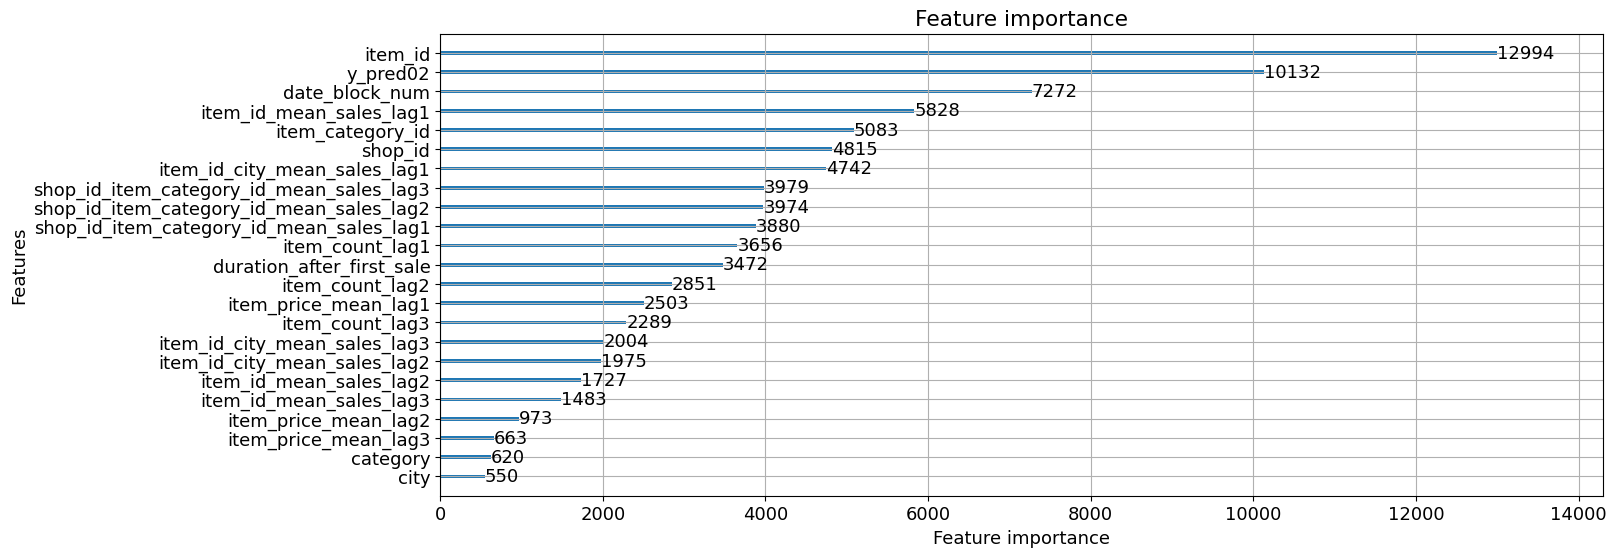

In [85]:
plt.rcParams["figure.figsize"] = (15, 6)
lgb.plot_importance(lgb_model, importance_type='split')
plt.show()